In [37]:
import boilerplate

import pyrtl
from pyrtl import *

# CPU Circuit Design

In [38]:
reset_working_block()

# Register file
sp = Register(bitwidth=16, name='sp') #, reset_value=5)
pc = Register(bitwidth=16, name='pc')
r = [Register(bitwidth=16, name='r%d' % i) for i in range(2)]
instr = WireVector(bitwidth=16, name='instr')

# Memories
mem = MemBlock(bitwidth=16, addrwidth=16, name="mem", max_read_ports=99, max_write_ports=40, asynchronous=True)
rom = RomBlock(bitwidth=16, addrwidth=16, name="rom", romdata=[0xf], pad_with_zeros=True, asynchronous=True)

In [39]:

def alu(op):
    res = WireVector(bitwidth=16)
    _ = AOP
    with op == _.ADD:
        res |= (r[0] + r[1])[:16]
    with op == _.SUB:
        res |= (r[0] - r[1])[:16]
    with op == _.MUL:
        res |= (r[0] * r[1])[:16]
    with op == _.DIV:
        # @todo need a specific circuit to emulate this
        pass
    with op == _.NEG:
        res |= (0 - r[0])[:16]
    with op == _.AND:
        res |= r[0] & r[1]
    with op == _.OR:
        res |= r[0] | r[1]
    with op == _.NOT:
        res |= ~r[0]
    with op == _.SHL:
        res |= shift_left_logical(r[0], r[1])
    with op == _.SHR:
        res |= shift_right_logical(r[0], r[1])
    with op == _.LT:
        res |= r[0] < r[1]

    return res
    

In [33]:
from instruction_set import *

instr <<= rom[pc]

op = instr[:4]
arg = instr[4:16]
earg = rom[(pc+1)[:16]]

sofs = lambda i: (sp - i)[:16]
st1 = sofs(1)
st2 = sofs(2)

with conditional_assignment:
    with op == HALT:
        pc.next |= pc
    with op == PUSH:
        mem[sp] |= earg
        sp.next |= sp + 1
        pc.next |= pc + 2
    with op == POP:
        with arg == 1:
            r[0].next |= mem[st1]
            sp.next |= st1
        with arg == 2:
            r[0].next |= mem[st2]
            r[1].next |= mem[st1]
            sp.next |= st2
        with otherwise:
            sp.next |= sp - arg
        pc.next |= pc + 1
    with op == DUP:
        mem[sp] |= mem[(st1 - arg)[:16]]
        sp.next |= sp + 1
        pc.next |= pc + 1
    with op == ALU:
        mem[sp] |= alu(arg)
        sp.next |= sp + 1
        pc.next |= pc + 1
    with op == YANK:
        take, drop = arg[:4], arg[4:]
        en = (op == YANK)
        ew = lambda v: MemBlock.EnabledWrite(v, en)
        # @note requires take <= 4
        mem[sofs(take+drop)]   <<= ew(mem[sofs(take)])
        mem[sofs(take+drop-1)] <<= ew(mem[sofs(take-1)])
        mem[sofs(take+drop-2)] <<= ew(mem[sofs(take-2)])
        mem[sofs(take+drop-3)] <<= ew(mem[sofs(take-3)])
        sp.next |= sp - drop
        pc.next |= pc + 1
    #with op == LOAD:
    #    mem[sp] |= mem[r[0]]
    #    sp.next |= sp + 1
    #    pc.next |= pc + 1
    #with op == STOR:
    #    mem[r[1]] |= r[0]
    #    pc.next |= pc + 1
    #with op == JMP:
    #    pc.next |= earg
    #with op == JZ:
    #    ???
    #with op == JNZ:
    #    ???
    #with op == RET:
    #    ???

### A Test program
This is a simple program in StASM, compiled to machine code using the module `assembler`.

In [15]:
from instruction_set import *
from assembler import asm

prog = asm([
    ('PUSH', 0x5),
    ('PUSH', 0x8),
    ('POP', 2),
    ('ALU', 'ADD'),
    ('POP', 1),
    ('HALT',0),
])

prog

Assembly(words=[91, 139, 41, 16, 25, 15], start_addr=0, label_addrs={})

## Simulation

This function here simulates the design using PyRTL's simulator. It populates the ROM with the compiled program's machine code and iterates until HALT is encountered.

In [16]:
from assembler import disasm

def simulate_program(prog, max_cycles=30, verbose=False):
    # Place the program in the ROM
    rom.data = prog.words
    
    sim_trace = pyrtl.SimulationTrace()
    sim = pyrtl.Simulation(tracer=sim_trace)
    for cycle in range(max_cycles):
        sim.step({})
        if verbose:
            m = sim.inspect_mem(mem)
            print(bin(sim.inspect(instr)), disasm([sim.inspect(instr)]),
                  hex(sim.inspect(pc)), hex(sim.inspect(r[0])), hex(sim.inspect(r[1])),
                  [m.get(i, 0) for i in range(min(sim.inspect(sp), 8))])
    
        if sim.inspect(instr) == HALT:
            break

    return sim_trace

simulate_program(prog, verbose=True).render_trace()

0b1011011 [('PUSH', 5)] 0x0 0x0 0x0 []
0b101001 [('POP', 2)] 0x2 0x0 0x0 [139]
0b10000 [('ALU', 1)] 0x3 0x0 0x8b [139, 0, 0, 0, 0, 0, 0, 0]
0b11001 [('POP', 1)] 0x4 0x0 0x8b []
0b1111 [('HALT', 0)] 0x5 0x8b 0x8b [139, 0, 0, 0, 0, 0, 0, 0]


<IPython.core.display.Javascript object>

##### _Debug ports_

In [17]:
d_sp = Output(name='d_sp', bitwidth=16)
d_pc = Output(name='d_pc', bitwidth=16)
d_instr = Output(name='d_instr', bitwidth=32)

d_sp <<= sp
d_pc <<= pc
d_instr <<= concat(instr, earg)

# Debug the lowest 16 memory addresses
d_memaddrs = range(16)
reads = [mem[i] for i in d_memaddrs]
arr = Output(bitwidth=len(reads)*16, name="d_mem")
arr <<= concat_list(reads)

In [34]:
import os
from simulate import CCompiledSimulation
from circuit import net_to_smt

In [35]:
mems = [mem, rom]
wires, ops, assertions = net_to_smt(working_block(), mems)

Z3Exception: b'Sorts (_ BitVec 17) and (_ BitVec 16) are incompatible'

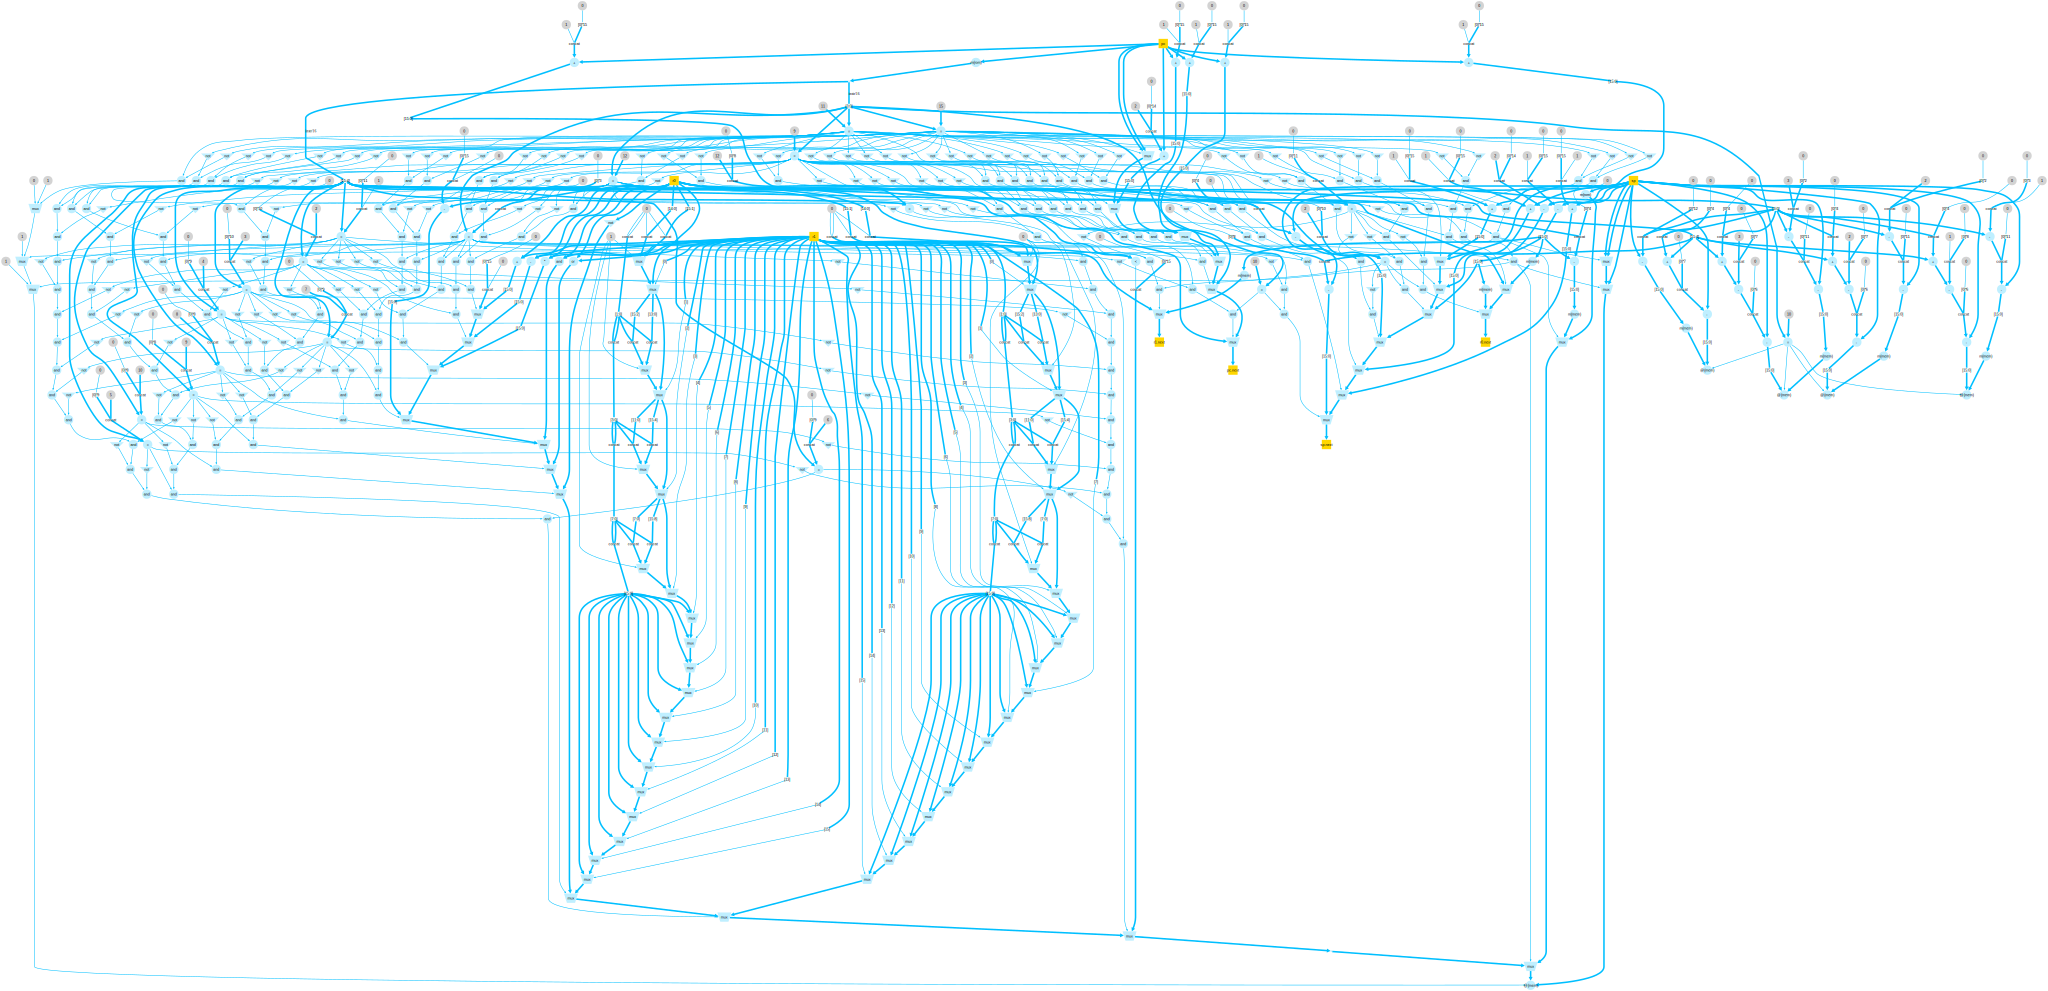

In [36]:
working_block()